In [ ]:
!pip install gluonts -i https://opentuna.cn/pypi/web/simple # gluonts[Prophet]

In [ ]:
!sudo yum install -y R readline-devel

# nnfor is optional
# !sudo R -e 'install.packages("remotes", repos="https://cloud.r-project.org")'
# !sudo R -e 'library(remotes) ; install_github("cran/plotrix")'
# !sudo R -e 'library(remotes) ; install_github("cran/glmnet")'
# !sudo R -e 'install.packages(c("nnfor"), repos="https://cloud.r-project.org", dependencies=TRUE)'

!sudo R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org", dependencies=TRUE)'

!pip install 'rpy2>=2.9.*,<3.*' -i https://opentuna.cn/pypi/web/simple  # Notice: gluonts need rpy2>=2.9.*,<3.*
# or use conda
#!conda install -c r rpy2 --yes

In [ ]:
!pip install pystan==2.14 -i https://opentuna.cn/pypi/web/simple  # LunarCalendar
!pip install fbprophet -i https://opentuna.cn/pypi/web/simple
# or below is better
# !conda install -c plotly plotly==3.10.0 --yes
# !conda install -c conda-forge fbprophet --yes

In [ ]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

## Data Prepare

In [ ]:
freq = '1H'
prediction_length = 3*24
context_length = 7*24

In [ ]:
def load_json(filename):
    data = []
    with open(filename, 'r') as fin:
        while True:
            line = fin.readline()
            if not line:
                break
            datai = json.loads(line)
            data.append(datai)
    return data

In [ ]:
train = load_json('train_'+freq+'.json')
test = load_json('test_'+freq+'.json')
predict = load_json('predict_'+freq+'.json')

# train = load_json('train_'+freq+'_Aug.json')
# test = load_json('test_'+freq+'_Aug.json')
# predict = load_json('predict_'+freq+'_Aug.json')

# train = load_json('train_'+freq+'_Nov.json')
# test = load_json('test_'+freq+'_Nov.json')
# predict = load_json('predict_'+freq+'_Nov.json')

# train = load_json('train_'+freq+'_Dec.json')
# test = load_json('test_'+freq+'_Dec.json')
# predict = load_json('predict_'+freq+'_Dec.json')

print(len(train[0]['target']), len(test[0]['target']), len(predict[0]['target']))

In [ ]:
num_timeseries = len(train)
print(num_timeseries)

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import to_pandas

In [ ]:
predict_list = []
for t in predict:
    if len(t['target'])>=prediction_length:
        predict_list.append({FieldName.TARGET: t['target'], FieldName.FEAT_STATIC_CAT: t['cat'], FieldName.FEAT_DYNAMIC_REAL: t['dynamic_feat'], FieldName.START: t['start'], FieldName.ITEM_ID: t['id']})

In [ ]:
train_ds = ListDataset([{FieldName.TARGET: t['target'], FieldName.FEAT_STATIC_CAT: t['cat'], FieldName.FEAT_DYNAMIC_REAL: t['dynamic_feat'], FieldName.START: t['start'], FieldName.ITEM_ID: t['id']}
                        for t in train], freq=freq)
test_ds = ListDataset([{FieldName.TARGET: t['target'], FieldName.FEAT_STATIC_CAT: t['cat'], FieldName.FEAT_DYNAMIC_REAL: t['dynamic_feat'], FieldName.START: t['start'], FieldName.ITEM_ID: t['id']}
                        for t in test], freq=freq)
predict_ds = ListDataset(predict_list, freq=freq)  

In [ ]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
grouper_train = MultivariateGrouper(max_target_dim=96)
train_ds_multi = grouper_train(train_ds)
test_ds_multi = grouper_train(test_ds)
predict_ds_multi = grouper_train(predict_ds)

In [ ]:
train_entry = next(iter(train_ds))
print(train_entry.keys())

In [ ]:
test_entry = next(iter(test_ds))
print(test_entry.keys())

In [ ]:
predict_entry = next(iter(predict_ds))
print(predict_entry.keys())

In [ ]:
def to_pandas_extend(instance: dict, feat_name: str = 'target', feat_index: int = 0, freq: str = None) -> pd.Series:
    """
    Transform a dictionary into a pandas.Series object, using its
    "start" and "target" fields.

    Parameters
    ----------
    instance
        Dictionary containing the time series data.
    freq
        Frequency to use in the pandas.Series index.

    Returns
    -------
    pandas.Series
        Pandas time series object.
    """
    if feat_name == 'target':
        target = instance[feat_name]
    else:
        target = instance[feat_name][feat_index]
    start = instance["start"]
    if not freq:
        freq = start.freqstr
    index = pd.date_range(start=start, periods=len(target), freq=freq)
    return pd.Series(target, index=index)

In [ ]:
train_series = to_pandas(train_entry)
train_series.plot()
for i in range(len(train_entry['feat_dynamic_real'])):
    train_dynamic_series = to_pandas_extend(train_entry, 'feat_dynamic_real', i)
    train_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["train series"]+['dynamic_feat_'+str(i) for i in range(len(train_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

In [ ]:
test_series = to_pandas(test_entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
for i in range(len(test_entry['feat_dynamic_real'])):
    test_dynamic_series = to_pandas_extend(test_entry, 'feat_dynamic_real', i)
    test_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["test series", "end of train series"]+['dynamic_feat_'+str(i) for i in range(len(test_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

In [ ]:
predict_series = to_pandas(predict_entry)
predict_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(test_series.index[-1], color='g') # end of test dataset
for i in range(len(predict_entry['feat_dynamic_real'])):
    predict_dynamic_series = to_pandas_extend(predict_entry, 'feat_dynamic_real', i)
    predict_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["predict series", "end of train series", "end of test series"]+['dynamic_feat_'+str(i) for i in range(len(predict_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

In [ ]:
def to_pandas_extend_sum(ds: ListDataset, feat_name: str = 'target', feat_index: int = 0, freq: str = None) -> pd.Series:
    result = None
    for predict_entry in iter(ds):
        predict_series = to_pandas_extend(predict_entry, feat_name, feat_index, freq)
        if result is None:
            result = predict_series
        else:
            result = result+predict_series
    if feat_name != 'target':
        result = result/num_timeseries
    return result

In [ ]:
predict_series = to_pandas_extend_sum(predict_ds, 'target')
predict_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(test_series.index[-1], color='g') # end of test dataset
for i in range(len(predict_entry['feat_dynamic_real'])):
    predict_dynamic_series = to_pandas_extend_sum(predict_ds, 'feat_dynamic_real', i)
    predict_dynamic_series.plot()
plt.grid(which="both")
plt.legend(["predict series", "end of train series", "end of test series"]+['dynamic_feat_'+str(i) for i in range(len(predict_entry['feat_dynamic_real']))], loc="upper left")
plt.show()

In [ ]:
estimators = {}
predictors = {}

## Estimator Model

In [ ]:
from gluonts.model.canonical import CanonicalRNNEstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.deepvar import DeepVAREstimator
from gluonts.model.gp_forecaster import GaussianProcessEstimator
from gluonts.model.gpvar import GPVAREstimator
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.n_beats import NBEATSEstimator
from gluonts.model.seq2seq import MQCNNEstimator, MQRNNEstimator, RNN2QRForecaster, Seq2SeqEstimator
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.wavenet import WaveNetEstimator

from gluonts.block.quantile_output import QuantileOutput
from gluonts.trainer import Trainer
from gluonts.block.encoder import Seq2SeqEncoder

In [ ]:
estimator = CanonicalRNNEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
)
estimators['CanonicalRNN'] = estimator

In [ ]:
estimator = DeepFactorEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
)
estimators['DeepFactor'] = estimator

In [ ]:
estimator = DeepAREstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
    use_feat_dynamic_real=True,  # True
    use_feat_static_cat=True,  # True
#     cardinality=[61]
    cardinality=[17]
)
estimators['DeepAR'] = estimator

In [ ]:
estimator = DeepStateEstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
    use_feat_dynamic_real=True,  # True
    use_feat_static_cat=True,  # True
#     cardinality=[61]
    cardinality=[17]
)
estimators['DeepState'] = estimator

In [ ]:
estimator = DeepVAREstimator(  # use multi
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
    target_dim=96
)
estimators['DeepVAR'] = estimator

In [ ]:
estimator = GaussianProcessEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
    #     cardinality=61
    cardinality=17
)
estimators['GaussianProcess'] = estimator

In [ ]:
estimator = GPVAREstimator(  # use multi
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
    target_dim=96
)
estimators['GPVAR'] = estimator

In [ ]:
estimator = LSTNetEstimator(  # use multi
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    num_series=96,
    skip_size=4,
    ar_window=4,
    channels=72,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
)
estimators['LSTNet'] = estimator

In [ ]:
estimator = NBEATSEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
)
estimators['NBEATS'] = estimator

In [ ]:
estimator = MQCNNEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
)
estimators['MQCNN'] = estimator

In [ ]:
estimator = MQRNNEstimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=context_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
)
estimators['MQRNN'] = estimator

In [ ]:
# # TODO
# estimator = RNN2QRForecaster(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# #     cardinality=[61]
#     cardinality=[17],
#     embedding_dimension=4,
#     encoder_rnn_layer=4,
#     encoder_rnn_num_hidden=4,
#     decoder_mlp_layer=[4],
#     decoder_mlp_static_dim=4
# )
# estimators['RNN2QR'] = estimator

In [ ]:
# # TODO
# estimator = Seq2SeqEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=context_length,
#     trainer=Trainer(ctx="cpu",
#                     epochs=200,
#                     learning_rate=1e-3,
#                     batch_size=32,
#                     num_batches_per_epoch=100
#                    ),
# #     cardinality=[61]
#     cardinality=[17],
#     embedding_dimension=4,
#     encoder=Seq2SeqEncoder(),
#     decoder_mlp_layer=[4],
#     decoder_mlp_static_dim=4
# )
# estimators['Seq2Seq'] = estimator

In [ ]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[40, 40],
    prediction_length=prediction_length,
    context_length=context_length,
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   )
)
estimators['SimpleFeedForward'] = estimator

In [ ]:
estimator = TransformerEstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
#     cardinality=[61]
    cardinality=[17]
)
estimators['Transformer'] = estimator

In [ ]:
estimator = WaveNetEstimator(
    freq=freq,
    prediction_length=prediction_length,
    trainer=Trainer(ctx="cpu",
                    epochs=200,
                    learning_rate=1e-3,
                    batch_size=32,
                    num_batches_per_epoch=100
                   ),
#     cardinality=[61]
    cardinality=[17]
)
estimators['WaveNet'] = estimator

In [22]:
%%time

for name, estimator in estimators.items():
    start = time.time()
    try:
        predictor1 = estimator.train(train_ds)
    except:
        predictor1 = estimator.train(train_ds_multi)
    predictors[name] = predictor1
    end = time.time()
    print(name, end-start)

100%|██████████| 100/100 [00:20<00:00,  4.80it/s, epoch=166/200, avg_epoch_loss=-2.06]

DeepAR 3540.4265463352203
CPU times: user 3h 56min, sys: 2min 46s, total: 3h 58min 46s
Wall time: 59min


In [ ]:
from pathlib import Path

In [ ]:
!mkdir -p gluonts_model/deepar/

# save the trained model in tmp/
predictor1.serialize(Path("gluonts_model/deepar/"))

In [ ]:
# loads it back
from gluonts.model.predictor import Predictor
predictor1 = Predictor.deserialize(Path("gluonts_model/deepar/"))

## Predictor Model

In [ ]:
from gluonts.model.naive_2 import Naive2Predictor
from gluonts.model.npts import NPTSPredictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

In [ ]:
# %%time
# # TODO Multiplicative seasonality is not appropriate for zero and negative values
# predictor2 = Naive2Predictor(freq=freq, prediction_length=prediction_length, season_length=context_length)
# predictors['Naive2'] = predictor2

In [ ]:
%%time

predictor2 = NPTSPredictor(freq=freq, prediction_length=prediction_length, context_length=context_length)
predictors['NPTS'] = predictor2

In [ ]:
%%time

def configure_model(model):
    model.add_seasonality(
        name='weekly', period=7, fourier_order=3, prior_scale=0.1
    )
    return model

predictor2 = ProphetPredictor(freq=freq,
                              prediction_length=prediction_length,
                              init_model=configure_model)
predictors['Prophet'] = predictor2

In [ ]:
%%time
# TODO
predictor2 = RForecastPredictor(freq=freq,
                              prediction_length=prediction_length,
                              method_name='arima',  # The method from rforecast to be used one of “ets”, “arima”, “tbats” (bug), “croston” (bug), “mlp” (bug).
                              period=context_length,
                              trunc_length=len(train[0]['target']))
predictors['ARIMA'] = predictor2

In [ ]:
%%time

predictor2 = SeasonalNaivePredictor(freq=freq, prediction_length=prediction_length)
predictors['SeasonalNaive'] = predictor2

## Select a predictor

In [23]:
# predictor = predictor1
# predictor = predictor2
predictor = predictors['DeepAR']  # SeasonalNaive

## Evaluation

In [24]:
%%time

from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=predict_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
print(len(forecasts), len(tss))

96 96
CPU times: user 15.8 s, sys: 734 ms, total: 16.5 s
Wall time: 3.73 s


## Evaluate All

In [25]:
%%time

from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(predict_ds))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 96/96 [00:00<00:00, 1106.91it/s]


{
    "MSE": 0.4242446650697003,
    "abs_error": 1579.0352071374655,
    "abs_target_sum": 4465.389278888702,
    "abs_target_mean": 0.646034328542926,
    "seasonal_error": 0.19390923337500898,
    "MASE": 2.1213109508416905,
    "MAPE": 0.4067013106016318,
    "sMAPE": 0.8352045983486903,
    "OWA": NaN,
    "MSIS": 24.25924195599407,
    "QuantileLoss[0.1]": 600.353397468185,
    "Coverage[0.1]": 0.13498263888888892,
    "QuantileLoss[0.5]": 1579.035206981123,
    "Coverage[0.5]": 0.3546006944444446,
    "QuantileLoss[0.9]": 1028.8095305312654,
    "Coverage[0.9]": 0.6218171296296299,
    "RMSE": 0.651340667446537,
    "NRMSE": 1.0082137104317335,
    "ND": 0.3536164729473348,
    "wQuantileLoss[0.1]": 0.13444592620547394,
    "wQuantileLoss[0.5]": 0.35361647291232273,
    "wQuantileLoss[0.9]": 0.23039638120582948,
    "mean_absolute_QuantileLoss": 1069.399378326858,
    "mean_wQuantileLoss": 0.2394862601078754,
    "MAE_Coverage": 0.15285493827160482
}
CPU times: user 20.5 ms, sys

In [26]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,sd001,0.102791,17.570435,26.978001,0.374694,0.093771,2.602449,0.659265,0.754833,NaN,8.978093,5.317340,0.027778,17.570435,0.388889,6.923779,0.680556
1,sd002,0.046532,13.429893,36.414001,0.505750,0.118875,1.569096,0.350246,0.438254,NaN,8.215341,5.100562,0.027778,13.429893,0.097222,7.164863,0.527778
2,sd003,0.000497,0.408069,0.621000,0.008625,0.056223,0.100806,0.541649,0.534197,NaN,3.213629,0.280325,0.027778,0.408069,0.638889,0.754935,1.000000
3,sd004,0.000030,0.295293,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,NaN,0.000000,0.216808,0.375000,0.295293,0.722222,0.104909,1.000000
4,sd005,0.000038,0.138248,0.081000,0.001125,0.012893,0.148928,0.039553,1.992197,NaN,3.587740,0.065706,0.027778,0.138248,0.847222,0.181018,0.958333


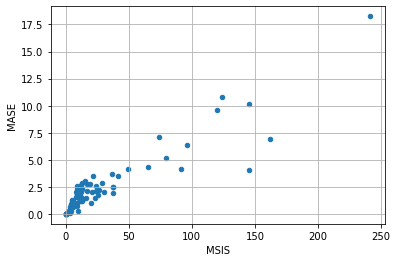

In [27]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

<AxesSubplot:>

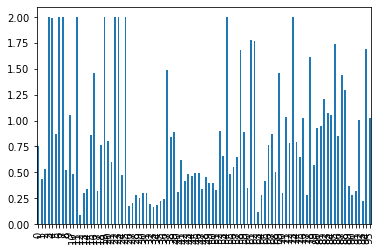

In [28]:
item_metrics['sMAPE'].plot(kind='bar')

<AxesSubplot:xlabel='sMAPE'>

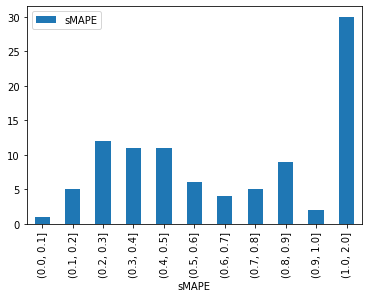

In [29]:
quartiles = pd.cut(item_metrics.sMAPE, [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2])
#print(quartiles)
def get_stats(group):
    return {'sMAPE': group.count()}
grouped = item_metrics.sMAPE.groupby(quartiles)
price_bucket_amount = grouped.apply(get_stats).unstack()
#price_bucket_amount
price_bucket_amount.plot(kind='bar')

In [30]:
item_metrics['sMAPE'].idxmin(), item_metrics['sMAPE'].min(), item_metrics['sMAPE'].idxmax(), item_metrics['sMAPE'].max()

(12, 0.08950699190109045, 3, 2.0)

### Visualize a Result

In [31]:
def plot_prob_forecasts(ts_entry, forecast_entry):
#     print('ts_entry:', ts_entry)
#     print('forecast_entry:', forecast_entry)
    plot_length = context_length+prediction_length
    prediction_intervals = (50.0, 90.0)
#     prediction_intervals = [80.0]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    pd.plotting.register_matplotlib_converters()  # https://stackoverflow.com/questions/43206554/typeerror-float-argument-must-be-a-string-or-a-number-not-period
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='orange')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [32]:
def show_metrics(customer_id=0, target_quantile=0.5, plot_graph=True):

    # first entry of the time series list
    ts_entry = tss[customer_id]

    # first 5 values of the time series (convert from pandas to numpy)
    # print(np.array(ts_entry[:5]).reshape(-1,))

    # first entry of dataset.test
    dataset_test_entry = next(iter(predict_ds))

    # first 5 values
    # print(dataset_test_entry['target'][:5])

    # first entry of the forecast list
    forecast_entry = forecasts[customer_id]

    if plot_graph:
        print(f"Number of sample paths: {forecast_entry.num_samples}")
        print(f"Dimension of samples: {forecast_entry.samples.shape}")
        print(f"Start date of the forecast window: {forecast_entry.start_date}")
        print(f"Frequency of the time series: {forecast_entry.freq}")

        print(f"Mean of the future window:\n {forecast_entry.mean}")
        print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
        print(f"target_value:\n {ts_entry[-prediction_length:].values.reshape((1, -1))}")

        plot_prob_forecasts(ts_entry, forecast_entry)
    
    y_label = list(ts_entry[-prediction_length:].values.reshape((1, -1))[0])
#     y_pred = list(forecast_entry.mean)
    y_pred = list(forecast_entry.quantile(target_quantile))
    return y_label, y_pred

In [48]:
target_quantile=0.7
y_labels = []
y_preds = []

for i in range(len(tss)):
    y_label, y_pred = show_metrics(i, target_quantile=target_quantile, plot_graph=False)
    y_labels.append(y_label)
    y_preds.append(y_pred)

In [49]:
from sklearn import metrics

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)/100

def eval_metric(a, f):
#     print('a:', a)
#     print('f:', f)
    new_a = []
    new_f = []
    for i in range(len(a)):
        if a[i] != 0:
            new_a.append(a[i])
            new_f.append(f[i])
    new_a = np.array(a)
    new_f = np.array(f)
#     print('new_a:', new_a)
#     print('new_f:', new_f)
    return np.mean((new_f-new_a)/new_a)

def eval_metric2(a, f):
#     print('a:', a)
#     print('f:', f)
    new_a = []
    new_f = []
    for i in range(len(a)):
        if a[i] != 0:
            new_a.append(a[i])
            new_f.append(f[i])
    new_a = np.array(a)
    new_f = np.array(f)
#     print('new_a:', new_a)
#     print('new_f:', new_f)
    return np.mean(np.abs(new_f-new_a)/np.abs(new_a))

print('y_labels:', len(y_labels))
print('y_preds:', len(y_preds))
y_labels = np.array(y_labels)
y_preds = np.array(y_preds)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_labels, y_preds)))
print("MAE:",metrics.mean_absolute_error(y_labels, y_preds))
print("Target Mean:",y_labels.mean())
smape_score = 0
smapes = []
rmses = []
maes = []
means = []
for i in range(y_labels.shape[0]):
    smapei = smape(y_labels[i], y_preds[i])
    rmsei = np.sqrt(metrics.mean_squared_error(y_labels[i], y_preds[i]))
    maei = metrics.mean_absolute_error(y_labels[i], y_preds[i])
    smape_score += smapei
    smapes.append(smapei)
    rmses.append(rmsei)
    maes.append(maei)
    means.append(y_labels[i].mean())
print("sMAPE:",smape_score/y_labels.shape[0])

y_labels: 96
y_preds: 96
RMSE: 0.75704
MAE: 0.22425209
Target Mean: 0.6460343
sMAPE: 0.7637692485032258


In [50]:
y_sum_labels = np.sum(y_labels, axis=0)
y_sum_preds = np.sum(y_preds, axis=0)
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_sum_labels, y_sum_preds)))
print("MAE:",metrics.mean_absolute_error(y_sum_labels, y_sum_preds))
print("SMAPE:", smape(y_sum_labels, y_sum_preds))
print("EVAL METRIC:", eval_metric(y_sum_labels, y_sum_preds))
print("EVAL METRIC2:", eval_metric2(y_sum_labels, y_sum_preds))
print("Target Mean:",y_sum_labels.mean())

RMSE: 4.8483515
MAE: 3.8999846
SMAPE: 0.06243983374701606
EVAL METRIC: 0.0023761417
EVAL METRIC2: 0.0625473
Target Mean: 62.019295


In [51]:
y_sum_labels

array([64.03653 , 68.537895, 72.6148  , 75.08879 , 80.31598 , 80.550735,
       71.82529 , 64.14833 , 62.98473 , 69.14499 , 69.1782  , 67.862076,
       67.34141 , 69.71132 , 72.6077  , 63.14518 , 74.19968 , 76.709595,
       70.1675  , 62.231792, 61.378033, 61.29847 , 59.694378, 68.15666 ,
       52.393673, 54.676167, 54.79268 , 57.069164, 54.10109 , 55.644165,
       59.08216 , 55.607006, 54.21974 , 49.95792 , 45.879837, 48.116917,
       55.853085, 52.04791 , 51.045753, 51.070316, 58.73992 , 54.553745,
       49.913155, 46.501835, 55.94517 , 53.68184 , 60.800663, 54.393505,
       59.13895 , 60.343754, 58.32816 , 59.44729 , 58.592297, 61.147327,
       58.439465, 58.601593, 60.40925 , 65.91396 , 60.67971 , 57.046337,
       64.00213 , 65.80212 , 65.126465, 59.45954 , 71.807236, 73.677025,
       68.59235 , 66.4498  , 66.05583 , 70.53667 , 66.88604 , 69.88842 ],
      dtype=float32)

In [52]:
y_sum_preds

array([70.06076 , 70.28747 , 71.14468 , 73.26427 , 72.38772 , 70.210815,
       70.43718 , 70.59125 , 68.69719 , 71.73447 , 74.44815 , 73.363365,
       71.596176, 73.81133 , 71.11346 , 70.21893 , 71.29601 , 72.97081 ,
       69.9423  , 63.263092, 64.597305, 66.75327 , 64.20888 , 60.589386,
       57.07352 , 53.778706, 55.51486 , 55.938095, 56.656704, 56.80986 ,
       56.717785, 54.97121 , 53.69288 , 53.11555 , 49.646683, 47.31717 ,
       53.157722, 55.61626 , 55.832806, 56.172955, 59.831764, 60.218567,
       60.193504, 56.651993, 58.628155, 58.66538 , 59.611916, 57.30893 ,
       58.430855, 58.076237, 58.11421 , 59.997646, 59.20162 , 58.360607,
       58.95854 , 57.78264 , 57.332756, 58.921036, 58.960773, 57.97686 ,
       57.84379 , 59.725777, 59.0905  , 59.10275 , 61.450985, 63.588882,
       61.233856, 58.19288 , 60.24237 , 62.80253 , 62.617325, 62.118782],
      dtype=float32)

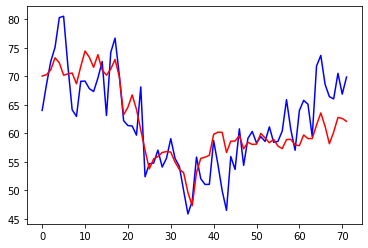

In [53]:
plt.plot(y_sum_labels,"b-",label="label")
plt.plot(y_sum_preds,"r-",label="predict")
plt.show()

# Evaluate All Models

DeepAR
96 96
RMSE: 4.7895
MAE: 3.807435
SMAPE: 0.061366640726725256
EVAL METRIC: -0.003970862
EVAL METRIC2: 0.061140895
Target Mean: 62.019295


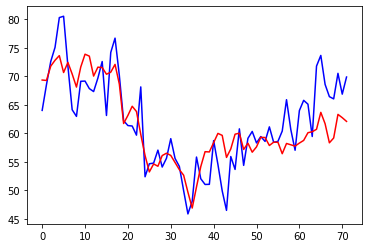

In [57]:
for name, predictor in predictors.items():
    print(name)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=predict_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(len(forecasts), len(tss))
    
    target_quantile = 0.7
    y_labels = []
    y_preds = []

    for i in range(len(tss)):
        y_label, y_pred = show_metrics(i, target_quantile=target_quantile, plot_graph=False)
        y_labels.append(y_label)
        y_preds.append(y_pred)
        
    y_sum_labels = np.sum(y_labels, axis=0)
    y_sum_preds = np.sum(y_preds, axis=0)
    print("RMSE:",np.sqrt(metrics.mean_squared_error(y_sum_labels, y_sum_preds)))
    print("MAE:",metrics.mean_absolute_error(y_sum_labels, y_sum_preds))
    print("SMAPE:", smape(y_sum_labels, y_sum_preds))
    print("EVAL METRIC:", eval_metric(y_sum_labels, y_sum_preds))
    print("EVAL METRIC2:", eval_metric2(y_sum_labels, y_sum_preds))
    print("Target Mean:",y_sum_labels.mean())
    
    plt.plot(y_sum_labels,"b-",label="label")
    plt.plot(y_sum_preds,"r-",label="predict")
    plt.show()